#  Прогнозирование заказов такси

Нужно построить модель, которая спрогнозирует количество заказов такси на следующий час.

Требование: значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

В нашем распоряжении данные из файла: `taxi.csv`.

## Импорт библиотек


In [ ]:
# Импортируем pandas как pd:
import pandas as pd
# Импортируем numpy как np:
import numpy as np
# Импорт библиотеки для граффиков:
import plotly.express as ex
import seaborn as sns
import matplotlib.pyplot as plt

# Импортируем модели:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_val_score
import lightgbm
from lightgbm import LGBMRegressor
!pip install catboost
from catboost import Pool, CatBoostRegressor
# Импорт методы для создания выборок:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
# Импортируем метрику:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
# Для анализа временных рядов:
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit
# Для загрузки файлов(у меня):
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00
Mounted at /content/drive


## Подготовка

### Загрузка данных:

In [ ]:
try:
  df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
  df = pd.read_csv("/content/drive/MyDrive/For_data/taxi.csv", index_col=[0], parse_dates=[0])

In [ ]:
df.sort_index(inplace=True)

In [ ]:
# Создание функции для изучения данных:
def information(data):
    print('Общая информация о таблице:')
    print(data.info(), '\n')
    print('Индекс монотонный? - ',data.index.is_monotonic)
    display(data.head(), '\n')
    print('Размер таблицы равен:', data.shape, '\n')
    print('Кол-во пропусков:', data.isna().sum(), '\n')
    print('Кол-во явных дубликатов:', data.duplicated().sum(), '\n')
    print('Статистические данные:')
    display(data.describe())

In [ ]:
# Изучение информации о таблице:
information(df)
# Создание граффика корреляций:
# ex.imshow(df.corr()) В нашем случае он не нужен.

Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None 

Индекс монотонный? -  True


<ipython-input-4-0a1ba0b309d3>:5: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  print('Индекс монотонный? - ',data.index.is_monotonic)


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


'\n'

Размер таблицы равен: (26496, 1) 

Кол-во пропусков: num_orders    0
dtype: int64 

Кол-во явных дубликатов: 26415 

Статистические данные:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Вывод:
У нас есть таблица размером 26496 строк. Индексом служит время, в столбце num_orders находится целевой признак - кол-во заказов.

Можем наблюдать явные дубликаты, но это не они(разное время, дата, но одинаковое кол-во заказов). Оставляем так как есть( иначе при удаление останется <90 строк).

In [ ]:
# Ресемплинг по 1 часу:
df = df.resample('1H').sum()

### Формирование данных для обучения:


In [ ]:
# Создание функции для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

In [ ]:
# Создание признаков
make_features(df, 24, 1)

In [ ]:
# Создание обучающей и тестовой выборки:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

## Анализ

In [ ]:
# информация о таблицы после создания признаков
information(df)

Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   year          4392 non-null   int64  
 2   month         4392 non-null   int64  
 3   day           4392 non-null   int64  
 4   dayofweek     4392 non-null   int64  
 5   lag_1         4392 non-null   float64
 6   lag_2         4392 non-null   float64
 7   lag_3         4392 non-null   float64
 8   lag_4         4392 non-null   float64
 9   lag_5         4392 non-null   float64
 10  lag_6         4392 non-null   float64
 11  lag_7         4392 non-null   float64
 12  lag_8         4392 non-null   float64
 13  lag_9         4392 non-null   float64
 14  lag_10        4392 non-null   float64
 15  lag_11        4392 non-null   float64
 16  lag_12        4392 non-null   float64
 17 

<ipython-input-4-0a1ba0b309d3>:5: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2018,3,2,4,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.0
2018-03-02 01:00:00,120,2018,3,2,4,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,90.0
2018-03-02 02:00:00,75,2018,3,2,4,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,120.0
2018-03-02 03:00:00,64,2018,3,2,4,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,75.0
2018-03-02 04:00:00,20,2018,3,2,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,64.0


'\n'

Размер таблицы равен: (4392, 30) 

Кол-во пропусков: num_orders      0
year            0
month           0
day             0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64 

Кол-во явных дубликатов: 0 

Статистические данные:


,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
count,4392.000000,4392.0,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,...,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000
mean,84.573543,2018.0,5.519126,15.918033,3.005464,84.540073,84.515027,84.493852,84.472678,84.451958,...,84.152322,84.145264,84.140027,84.123634,84.072404,84.064891,84.028689,84.003871,83.969262,84.540073
std,45.050123,0.0,1.707912,8.811011,1.996117,45.015225,44.968748,44.955561,44.944716,44.941932,...,44.723919,44.732387,44.739487,44.754926,44.673101,44.673365,44.619468,44.588590,44.498432,45.015225
min,0.000000,2018.0,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,2018.0,4.000000,8.000000,1.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
50%,78.000000,2018.0,6.000000,16.000000,3.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
75%,108.000000,2018.0,7.000000,24.000000,5.000000,108.000000,108.000000,107.250000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,108.000000
max,462.000000,2018.0,8.000000,31.000000,6.000000,462.000000,462.000000,462.000000,462.000000,462.000000,...,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000


In [ ]:
# Граффик корреляций:
ex.imshow(df.corr())

Достаточно большая корреляция между целью и признаками , что хорошо для обучения модели.

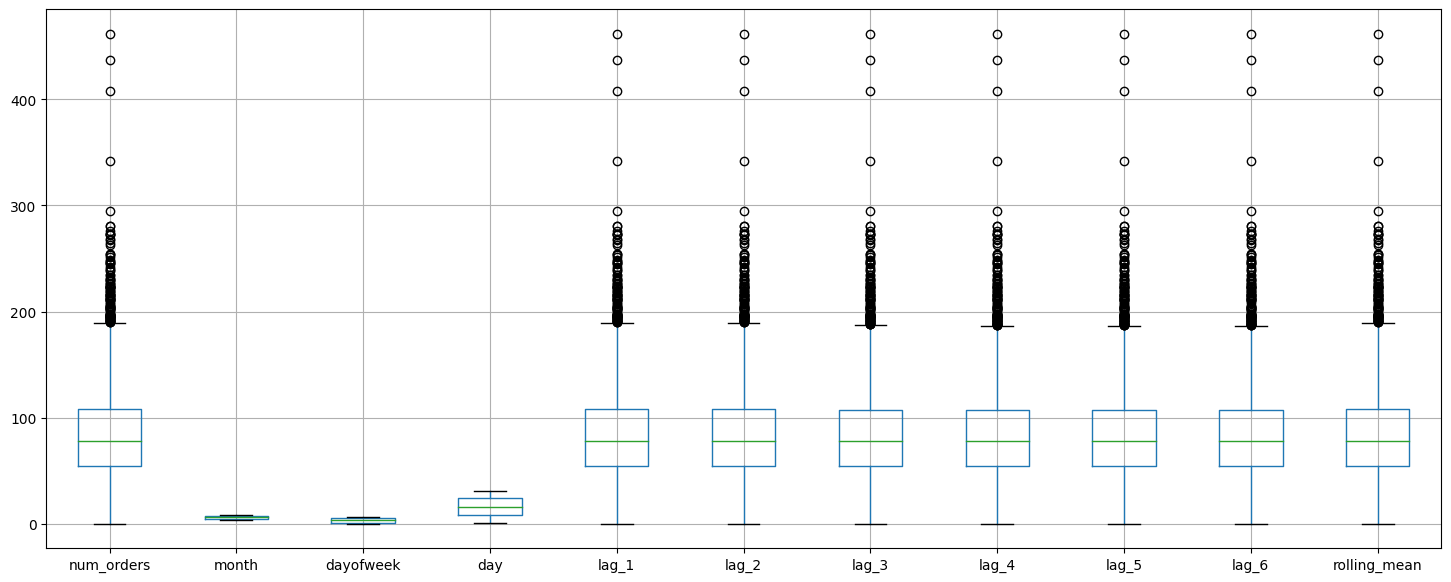

In [ ]:
boxplot = df.boxplot(column=['num_orders', 'month', 'dayofweek', 'day',
                             'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6','rolling_mean' ], figsize=(18,7))
plt.show()

По данным 'боксплотам' можем увидить, что у нас довольно большое кол-во дней когда показатели выше 'нормального'. Считаю что можно оставить и так.

In [ ]:
decomposed = seasonal_decompose(df['num_orders'])

<Axes: xlabel='datetime'>

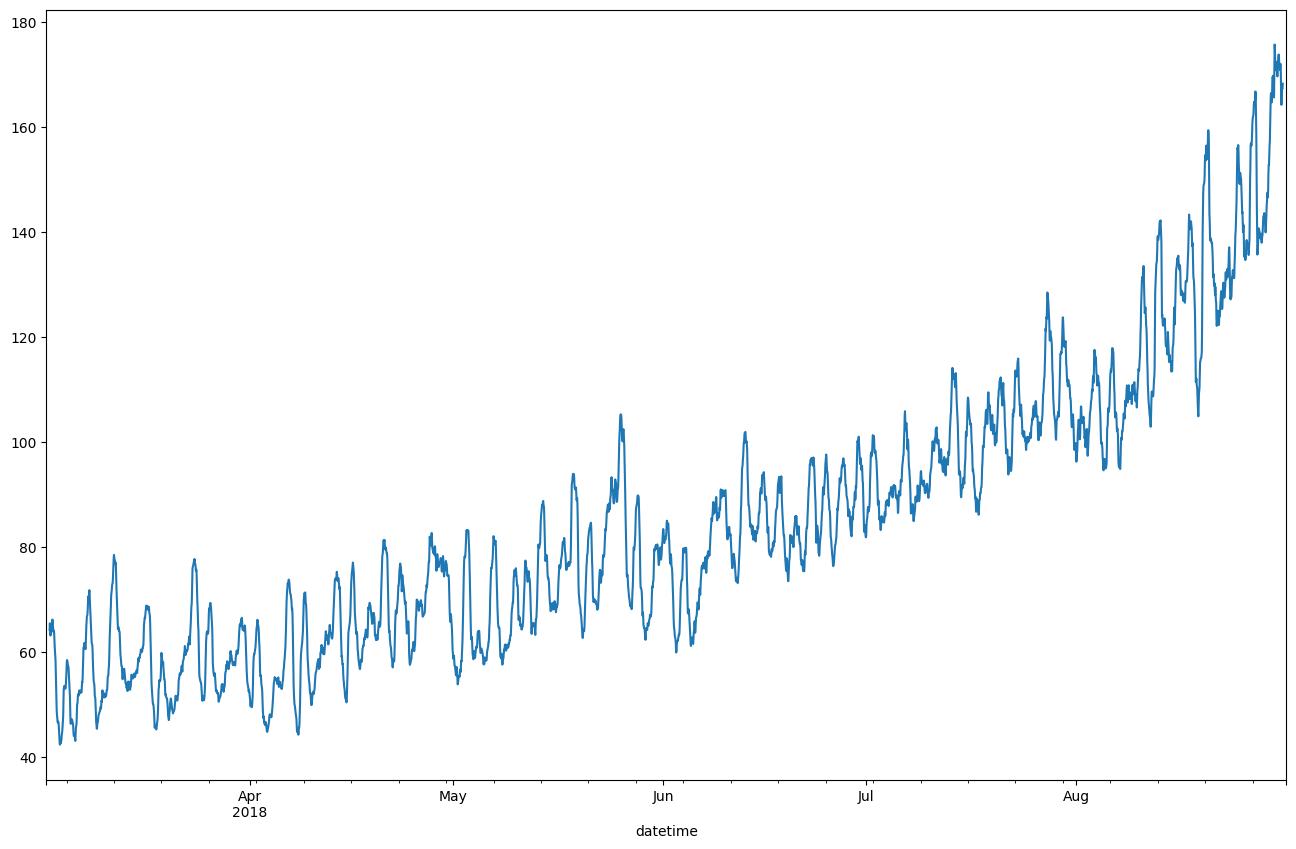

In [ ]:
decomposed.trend.plot(figsize=(16,10))

#### Вывод:
По граффику видно, что кол-во заказов только растёт, очень значительный прирост в конце временного промежутка этой таблицы. Рост больше похож на квадратный или близкий к этому.

Признаки lag_ не отображаются на графике. Календарные признаки отображаются как и надо(день месяца растёт с каждыйм днём и падает в начале следующего и тд).

## Обучение

In [ ]:
# Обьявление ТаймСплит, чтобы не было кросс валидации в гридсёрче:
tscv = TimeSeriesSplit(n_splits=2)

### LightGBM:

In [ ]:
params = {
    'num_leaves': [5, 20, 35, 50],
    'learning_rate': [0.5, 0.1, 0.05],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 150, 300]
}
lgb = LGBMRegressor(metric='neg_root_mean_squared_error')
lgb_grid_clf = GridSearchCV(lgb, cv=tscv, param_grid=params)
lgb_grid_clf.fit(train_features, train_target)

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=LGBMRegressor(metric='neg_root_mean_squared_error'),
             param_grid={'learning_rate': [0.5, 0.1, 0.05],
                         'max_depth': [-1, 3, 5],
                         'n_estimators': [50, 150, 300],
                         'num_leaves': [5, 20, 35, 50]})

### Дерево решений:

In [ ]:
# Параметр для модели(перебор):
parameters = {'max_depth':range(1,21,1),}
# Инициализация модели:
model_tree = DecisionTreeRegressor(random_state=12345)
# Подбор гипперпараметров:
model_tree_grid_clf = GridSearchCV(model_tree, cv=tscv, param_grid = parameters, scoring='neg_root_mean_squared_error')
# Обучение модели:
model_tree_grid_clf.fit(train_features, train_target)
# Вывод параметров:
print('Параметры модели:',model_tree_grid_clf.best_params_)

Параметры модели: {'max_depth': 3}


### CatBoost:

In [ ]:
cat = CatBoostRegressor()
params_for_cat = {
    'learning_rate': [0.5, 0.1, 0.05],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 150, 300]
}
cat_grid = GridSearchCV(cat, cv=tscv, param_grid=params_for_cat)
cat_grid.fit(train_features, train_target, verbose=50)

0:	learn: 25.3977606	total: 47.6ms	remaining: 2.33s
49:	learn: 14.2217563	total: 115ms	remaining: 0us
0:	learn: 27.5566966	total: 1.8ms	remaining: 88.1ms
49:	learn: 17.7528929	total: 74.1ms	remaining: 0us
0:	learn: 25.3977606	total: 1.29ms	remaining: 192ms
50:	learn: 14.2067882	total: 54.6ms	remaining: 106ms
100:	learn: 11.1494111	total: 117ms	remaining: 56.7ms
149:	learn: 9.2905890	total: 177ms	remaining: 0us
0:	learn: 27.5566966	total: 1.64ms	remaining: 244ms
50:	learn: 17.6569676	total: 84.5ms	remaining: 164ms
100:	learn: 14.9787030	total: 157ms	remaining: 76ms
149:	learn: 13.2508424	total: 233ms	remaining: 0us
0:	learn: 25.3977606	total: 1.18ms	remaining: 353ms
50:	learn: 14.2067882	total: 56.7ms	remaining: 277ms
100:	learn: 11.1494111	total: 115ms	remaining: 227ms
150:	learn: 9.2561668	total: 190ms	remaining: 188ms
200:	learn: 7.6477115	total: 354ms	remaining: 174ms
250:	learn: 6.4095317	total: 516ms	remaining: 101ms
299:	learn: 5.4447350	total: 622ms	remaining: 0us
0:	learn: 27.5

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5704, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2303, in _fit
    train_par

0:	learn: 37.0126892	total: 5.07ms	remaining: 1.51s
50:	learn: 23.4815378	total: 201ms	remaining: 979ms
100:	learn: 21.4257170	total: 406ms	remaining: 800ms
150:	learn: 19.7016882	total: 601ms	remaining: 593ms
200:	learn: 18.3008165	total: 798ms	remaining: 393ms
250:	learn: 17.2756489	total: 1.01s	remaining: 198ms
299:	learn: 16.2156855	total: 1.23s	remaining: 0us


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7db09301af20>,
             param_grid={'learning_rate': [0.5, 0.1, 0.05],
                         'max_depth': [-1, 3, 5],
                         'n_estimators': [50, 150, 300]})

## Тестирование

In [ ]:
# Тестирование LightGBM, получение Значения метрики:
lightgbmpredict = lgb_grid_clf.predict(test_features)
lgb_result = mean_squared_error(test_target, lightgbmpredict, squared=False)
print('RMSE LightGBM:',lgb_result)

RMSE LightGBM: 42.466497538066335


In [ ]:
# Тестирование Дерева решений, получение Значения метрики:
model_tree_grid_clf_predictions = model_tree_grid_clf.predict(test_features)
model_tree_grid_clf_result = mean_squared_error(test_target, model_tree_grid_clf_predictions, squared=False)
print('RMSE дерева решений:',model_tree_grid_clf_result)

RMSE дерева решений: 56.40077266633896


In [ ]:
# Тестирование CatBoost, получение Значения метрики:
cat_predictions = cat_grid.predict(test_features)
cat_result = mean_squared_error(test_target, cat_predictions, squared=False)
print('RMSE CatBoost:',cat_result)

RMSE CatBoost: 40.297765133700054


Лучше всех по качеству метрики показала CatBoost, по скорости работы все модели имели приблизительно одну скорость по выполнению в ячейке (Речь про предсказание). Обучение самая быстрая модель - Дерево решений. Catboost обучался 23 секунды, LightGBM - 1 минуту.

По качеству и скорости лучшей моделью является CatBoost. Значение метрики около 40

# Вывод:

# Лучшей моделью является - CatBoost.

## В данном проекте были предприняты следующие шаги:

### 1.) Полученна и анализирована общая информация о данных.

### 2.) Выполнена подготовка данных.

### 3.) Проведена работа с разными моделями.

### 4.) Проверенно качество работы разных моделий на тестовой выборке.

### 5.) Сделан Вывод о лучшей модели / проекте.